# Import Modules

In [5]:
import os ## for handeling file path
import pickle ## for storing numpy feature
import numpy as np
from tqdm.notebook import tqdm # progress bar decorator for iterators
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

****Data Load****

In [6]:
BASE_DIR = '/kaggle/input/flickr8k'
WORKING_DIR = '/kaggle/working'

# Extract Image Features

In [7]:
#Load vgg16 model
model = VGG16()
# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
#Fully connected layer of the VGG16 model is not needed, just the previous layers to extract feature results.connected layer of the VGG16 model is not needed, just the previous layers to extract feature results.
# summarize
print(model.summary())

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


****Now we extract the image features and load the data for preprocess****

In [8]:
# extract features from image
features = {} ### Dictionary Value
directory = os.path.join(BASE_DIR, 'Images')

for img_name in tqdm(os.listdir(directory)):
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2])) # RGB IMAGE SO HAVING THE SAME dimension
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # img_name.split('.')[0] - split of the image name from the extension(*jpg) to load only the image name
    # store feature
    features[image_id] = feature ## img id is the key

  0%|          | 0/8091 [00:00<?, ?it/s]

**thus for img_id we have it's  corresponding feature***

In [9]:
# store features in pickle
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb')) ## write binary


***Extracted features are not stored in the disk, so re-extraction of features can extend running time.***

***Dumps and store your dictionary in a pickle for reloading it to save time***




In [10]:
#load features from pickle
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f) # re4ad binary

***Load all your stored feature data to your project for quicker runtime***

# Load the Captions Data

Let us store the captions data from the text file

In [11]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)## as don't need thhe 1st line so skip it
    captions_doc = f.read()

**thus for img_id  now we need  it's  corresponding Captions***

In [12]:
#Now we split and append the captions data with the image
# create mapping of image to captions
mapping = {}
#Dictonary 'Mapping' is created with key as image_id and values as the corresponding caption text
# process lines
for line in tqdm(captions_doc.split('\n')):# taking line by line
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # if a image have multiple captions
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [13]:
# Now let us see the no. of images loaded
len(mapping)

8091

# Preprocess Text Data

In [14]:
# Defined to clean and convert the text for quicker process and better results
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
        # take one caption at a time
            caption = captions[i]
        # preprocessing steps
        # convert to lowercase
            caption = caption.lower()
        # delete digits, special chars, etc., 
            caption = caption.replace('[^A-Za-z]', '') ## except these
        # delete additional spaces
            caption = caption.replace('\s+', ' ')
        # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

#  visualize the text before and after cleaning

In [15]:
# before preprocess of text
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [16]:
# preprocess the text
clean(mapping)

In [17]:
#after preprocess of text
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

***Next we will store the preprocessed captions into a list***

In [18]:
all_captions =[]
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [19]:
len(all_captions)

40455

In [20]:
#Let us see the first ten captions
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

# processing the text data

In [21]:
#tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1


In [22]:
vocab_size #no of unique words

8485

In [23]:
# get maximum length of the caption available

max_length = max(len(caption.split()) for caption in all_captions)
max_length
# Finding the maximum length of the captions, used for reference for the padding sequence.

35


# Train Test Split

***After preprocessing the data now we will train, test and split***

In [24]:
image_ids=list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

*Explanatory example of the sequence split into pairs*

#startseq girl going into wooden building endseq

#X    ......................               y

#startseq                ......................                       girl


#startseq girl           ...................                        going

#startseq girl going        .......................                      into

#...........

#startseq girl going into wooden building      endseq

***Now we will define a batch and include the padding sequence***

In [25]:
# create data generator to get data in batch (avoids session crash)
### Optional

def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], 	num_classes=vocab_size)[0]
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield {"image": X1, "text": X2}, y
                X1, X2, y = list(), list(), list()
                n = 0





**Padding sequence normalizes the size of all captions to the max size filling them with zeros for better results.**


# MODEL 

In [26]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,), name="image") ### from the last VGG dense output length of the features
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)################ Dense - single dimension linear layer array
# sequence feature layers
inputs2 = Input(shape=(max_length,), name="text")
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)### padding the sequence so mask_zero
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)#########



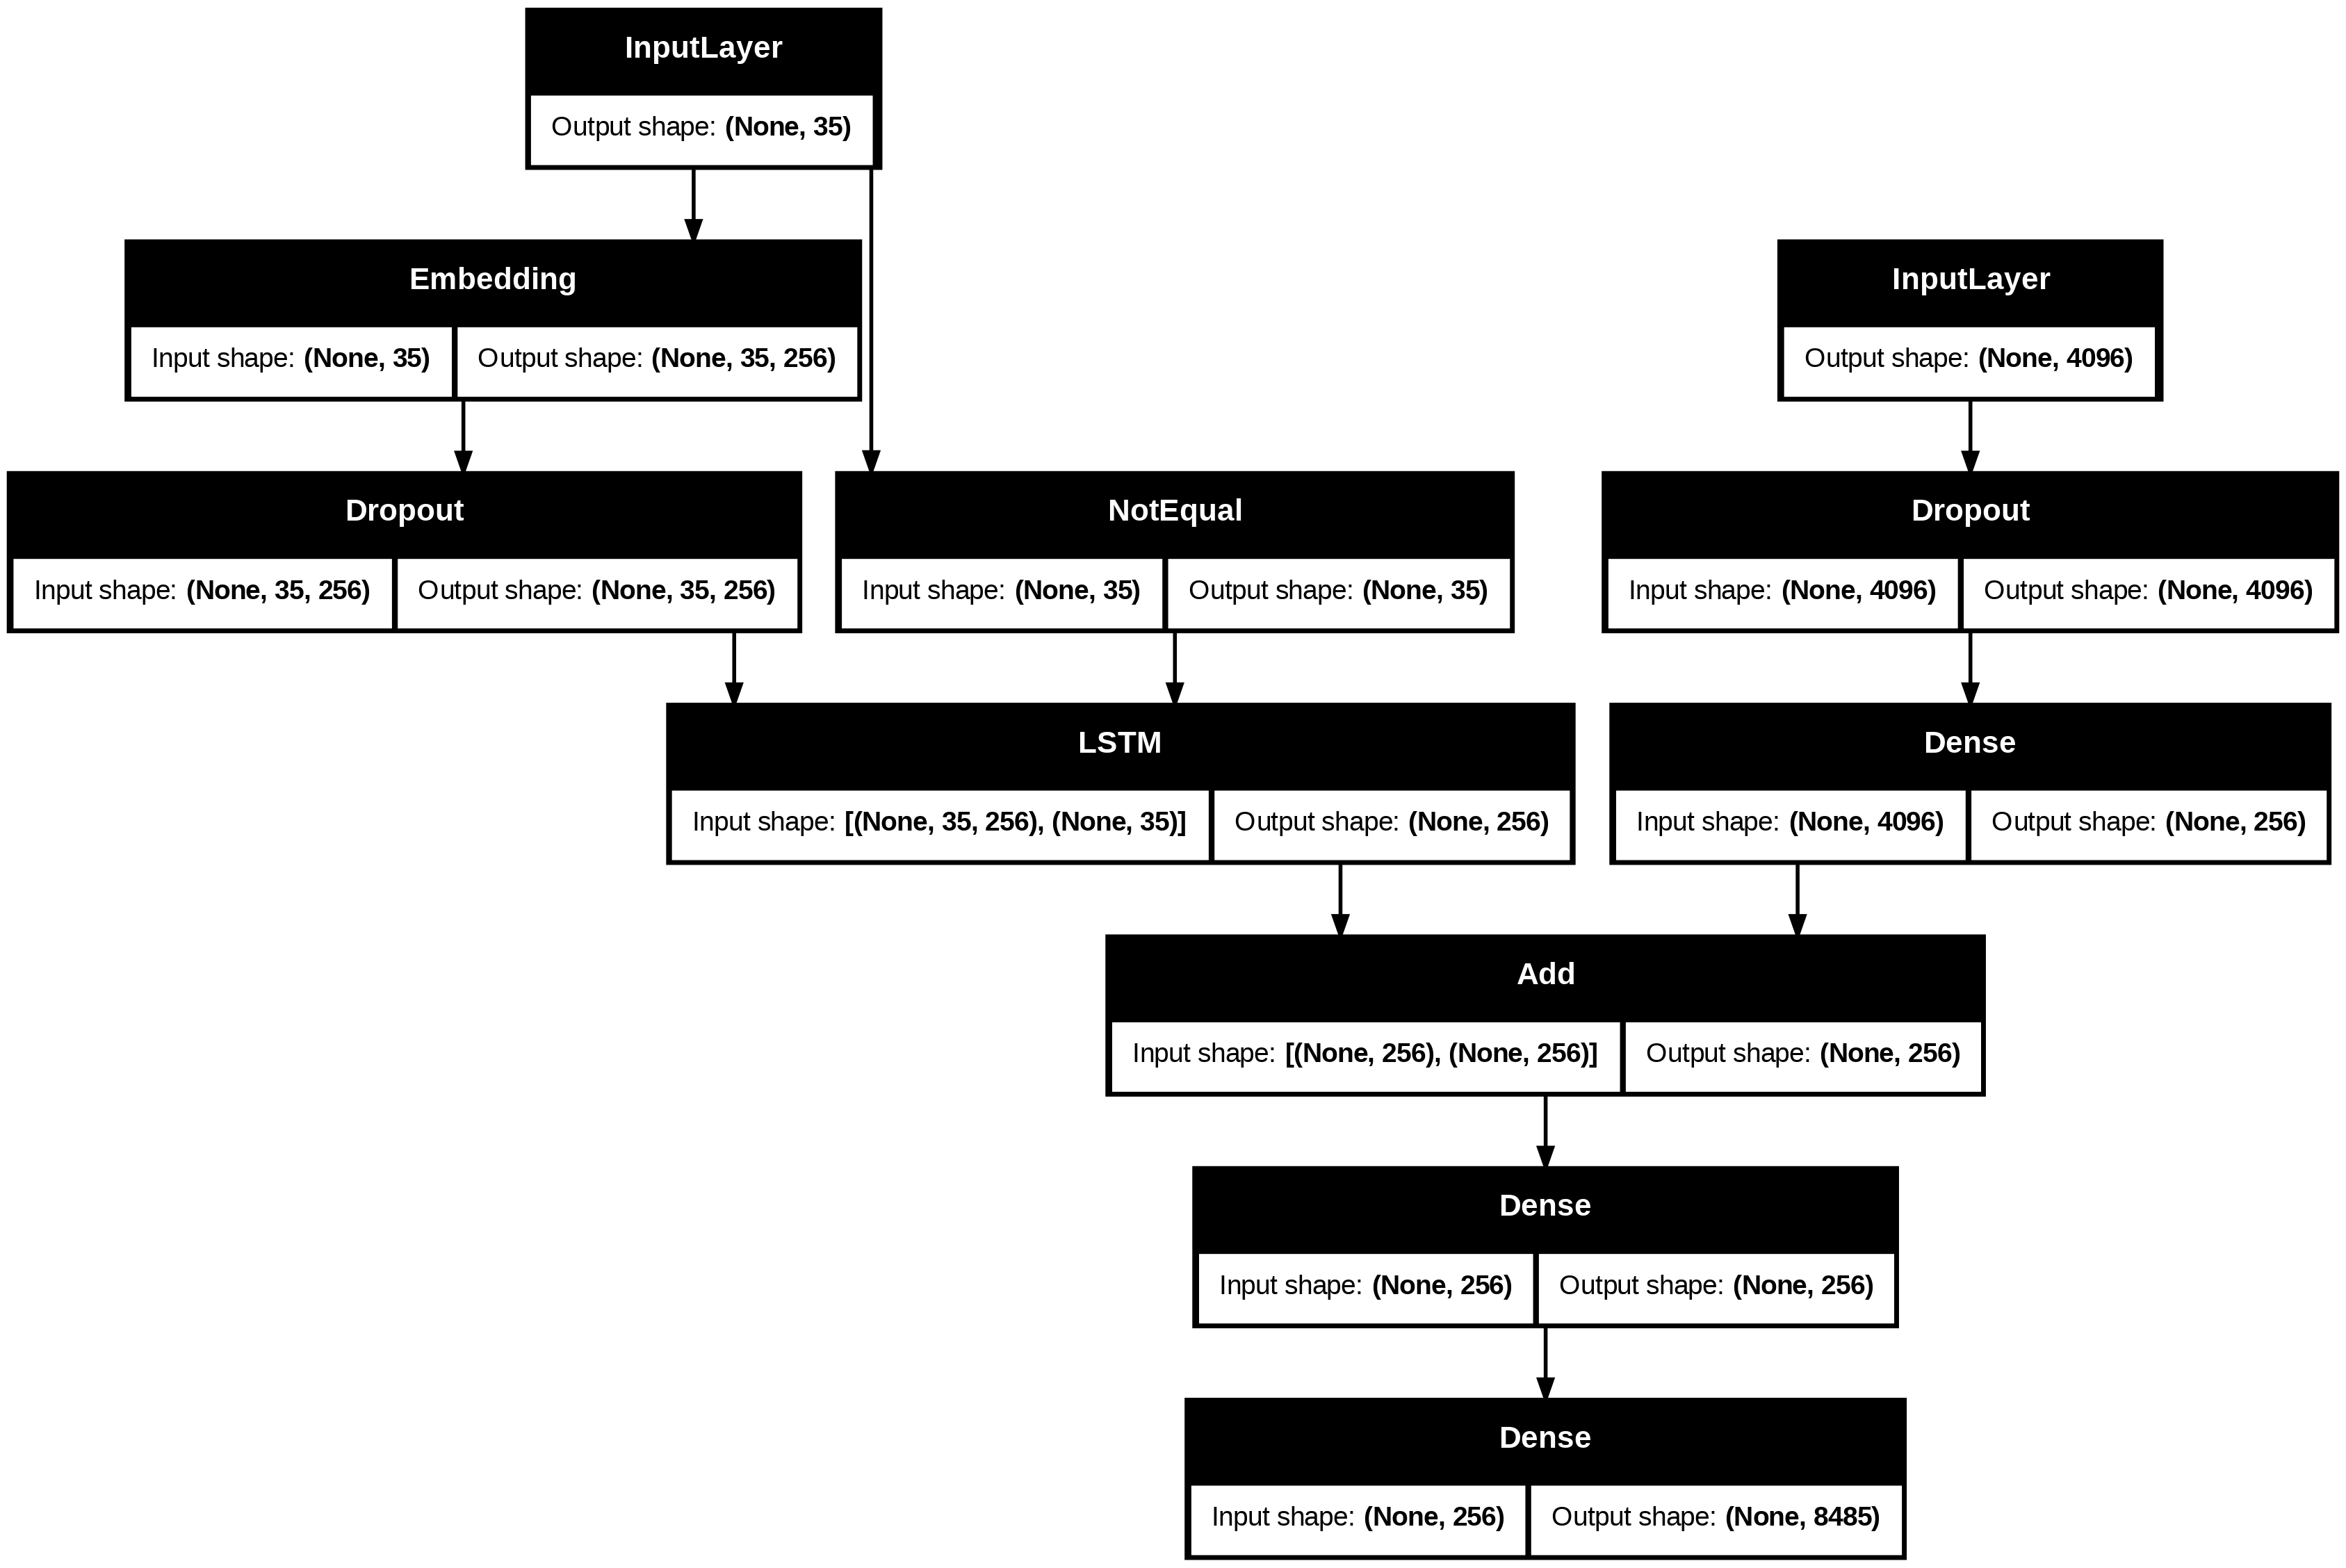

In [27]:
# decoder model
decoder1 = add([fe2, se3]) ### concatenate both the image and text feature
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')# loss=’sparse_categorical_crossentropy’ - loss function for category outputs

# plot the model
plot_model(model, show_shapes=True)
# Feature extraction of image was already done using VGG, no CNN model was needed in this step.

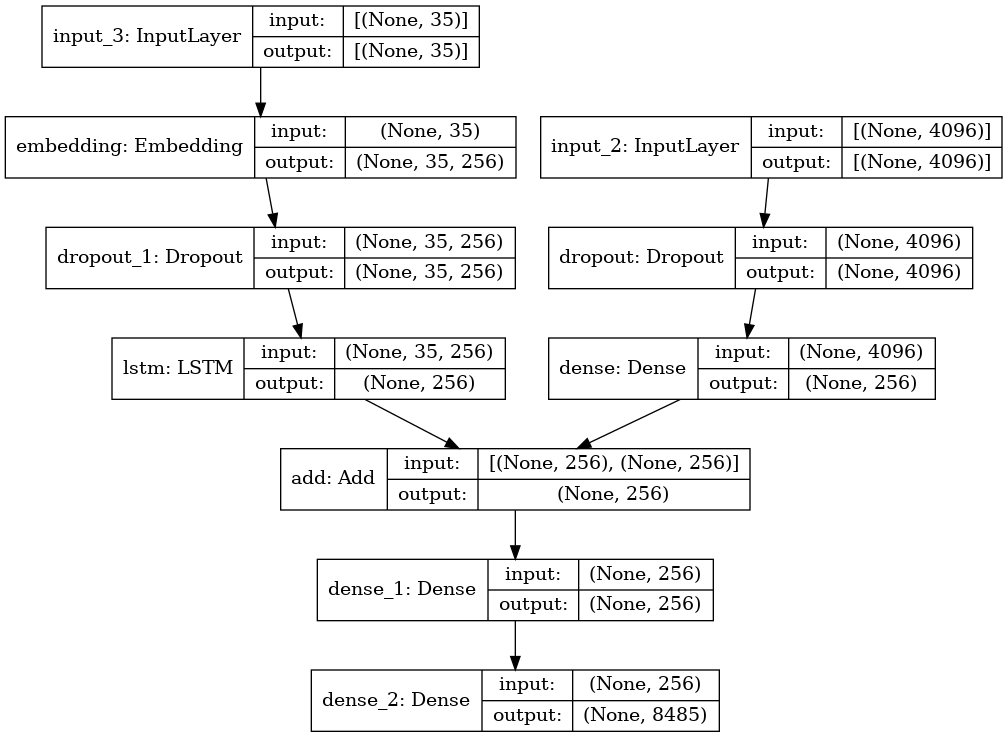

# TRAIN THE model

227/227 ━━━━━━━━━━━━━━━━━━━━ 61s 246ms/step - loss: 5.7852
227/227 ━━━━━━━━━━━━━━━━━━━━ 55s 243ms/step - loss: 4.0700
227/227 ━━━━━━━━━━━━━━━━━━━━ 56s 245ms/step - loss: 3.5896
227/227 ━━━━━━━━━━━━━━━━━━━━ 55s 243ms/step - loss: 3.3038
227/227 ━━━━━━━━━━━━━━━━━━━━ 55s 243ms/step - loss: 3.0962
227/227 ━━━━━━━━━━━━━━━━━━━━ 55s 243ms/step - loss: 2.9424
227/227 ━━━━━━━━━━━━━━━━━━━━ 55s 242ms/step - loss: 2.8202
227/227 ━━━━━━━━━━━━━━━━━━━━ 55s 241ms/step - loss: 2.7241
227/227 ━━━━━━━━━━━━━━━━━━━━ 54s 239ms/step - loss: 2.6465
227/227 ━━━━━━━━━━━━━━━━━━━━ 55s 241ms/step - loss: 2.5770
227/227 ━━━━━━━━━━━━━━━━━━━━ 55s 241ms/step - loss: 2.5219
227/227 ━━━━━━━━━━━━━━━━━━━━ 55s 244ms/step - loss: 2.4675
227/227 ━━━━━━━━━━━━━━━━━━━━ 55s 244ms/step - loss: 2.4171
227/227 ━━━━━━━━━━━━━━━━━━━━ 55s 244ms/step - loss: 2.3757
227/227 ━━━━━━━━━━━━━━━━━━━━ 55s 244ms/step - loss: 2.3347
227/227 ━━━━━━━━━━━━━━━━━━━━ 56s 247ms/step - loss: 2.3008
227/227 ━━━━━━━━━━━━━━━━━━━━ 55s 241ms/step - loss: 2.27

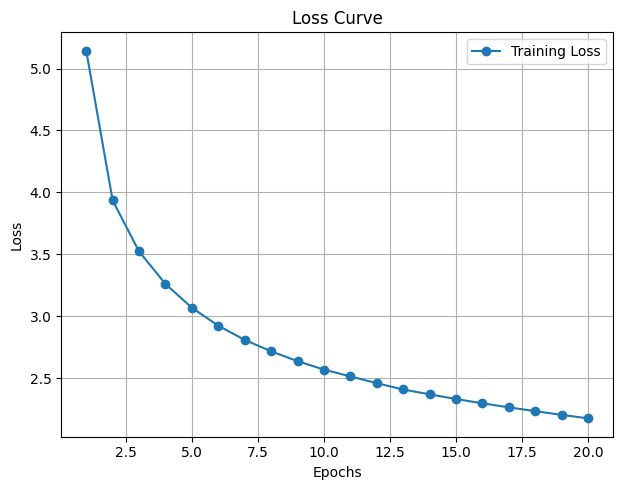

In [28]:
import matplotlib.pyplot as plt

# Initialize lists to store accuracy and loss
training_loss = []
training_accuracy = []

# Number of epochs and batch size
epochs = 20
batch_size = 32
steps = len(train) // batch_size

# Training loop
for i in range(epochs):
    # Create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    
    # Fit for one epoch and collect metrics
    history = model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    
    # Store the loss and accuracy from the current epoch
    training_loss.append(history.history['loss'][0])
    if 'accuracy' in history.history:
        training_accuracy.append(history.history['accuracy'][0])  # For classification tasks

# Plot accuracy and loss curves
plt.figure(figsize=(12, 5))

# Plot loss curve
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), training_loss, label="Training Loss", marker="o")
plt.title("Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# Plot accuracy curve (if applicable)
if training_accuracy:
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), training_accuracy, label="Training Accuracy", color="orange", marker="o")
    plt.title("Accuracy Curve")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


***Save the model in the working directory for reuse***

In [29]:
#save the model
model.save(WORKING_DIR+'/best_model.h5')

# Generate Captions for the Image

In [32]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
         return word
    return None

# Convert the predicted index from the model into a word

In [33]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length, padding='post')
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
    return in_text

***Now we validate the data using BLEU Score***

In [34]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key] ##### actual caption
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)

    # calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.535222
BLEU-2: 0.308531


 BLEU Score is used to evaluate the predicted text against a reference text, in a list of tokens.

The reference text contains all the words appended from the captions data (actual_captions)

A BLEU Score more than 0.4 is considered a good result, for a better score increase the no. of epochs accordingly.

# Visualiize the Results

In [35]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1077546505_a4f6c4daa9.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual DATA---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted DATA--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual DATA---------------------
startseq child playing on rope net endseq
startseq little girl climbing on red roping endseq
startseq little girl in pink climbs rope bridge at the park endseq
startseq small child grips onto the red ropes at the playground endseq
startseq the small child climbs on red ropes on playground endseq
--------------------Predicted DATA--------------------
startseq the little girl in red is climbing red ropes endseq


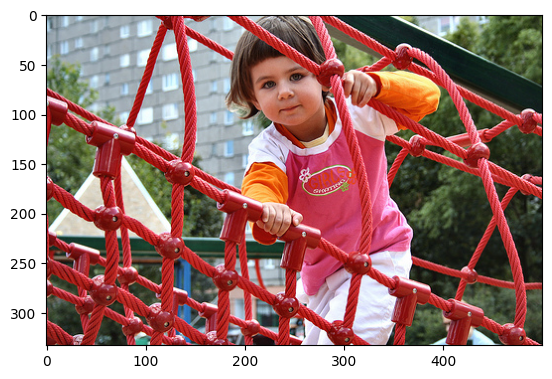

In [36]:
generate_caption("1007320043_627395c3d8.jpg")

---------------------Actual DATA---------------------
startseq black and white dog jumping in the air to get toy endseq
startseq black and white dog jumps up towards yellow toy endseq
startseq dog leaps to catch ball in field endseq
startseq white dog is trying to catch ball in midair over grassy field endseq
startseq the white dog is playing in green field with yellow toy endseq
--------------------Predicted DATA--------------------
startseq dog jumps to catch ball in field endseq


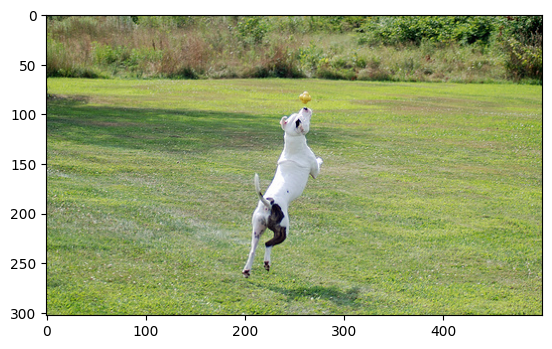

In [37]:
generate_caption("1020651753_06077ec457.jpg")

---------------------Actual DATA---------------------
startseq man and baby are in yellow kayak on water endseq
startseq man and little boy in blue life jackets are rowing yellow canoe endseq
startseq man and child kayak through gentle waters endseq
startseq man and young boy ride in yellow kayak endseq
startseq man and child in yellow kayak endseq
--------------------Predicted DATA--------------------
startseq man in yellow kayak is floating in the water endseq


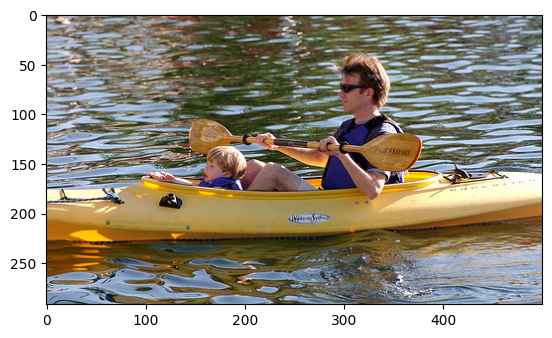

In [38]:
generate_caption("1028205764_7e8df9a2ea.jpg")